In [1]:
import os
os.chdir("../Figure5")

# Figure5a

In [2]:
import sys
from Bio import SeqIO

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import seaborn as sns

In [3]:
def get_entropy(nucls):
    wo_gaps = nucls[nucls != '-']
    
    ch, cn = np.unique(wo_gaps, return_counts=True)
    d = {c:n for c, n in zip(ch, cn)}
        
    entropy = 0
    for c in d:
        if c == '-':
            continue
        p = d[c] / wo_gaps.shape[0]
        entropy -= p * np.log2(p)
        
    if len(d) > 1:
        entropy /= np.log2(len(d))
        
    return entropy

In [4]:
def get_positional_entropies(file_name):
    parser = SeqIO.parse(file_name, format='fasta')

    tmp = []
    for record in parser:
        tmp.append(list(record.seq))

    seqs = np.array(tmp)
    
    entropies = [get_entropy(seqs[:, idx]) for idx in range(seqs.shape[1])]
    
    return {'positions': range(seqs.shape[1]), 'entropy': entropies}

In [5]:
entropy_a = get_positional_entropies("Aedes_genus.msa.fasta")
entropy_b = get_positional_entropies("Aedes_four.msa.fasta")
entropy_c = get_positional_entropies("Aedes_three.msa.fasta")

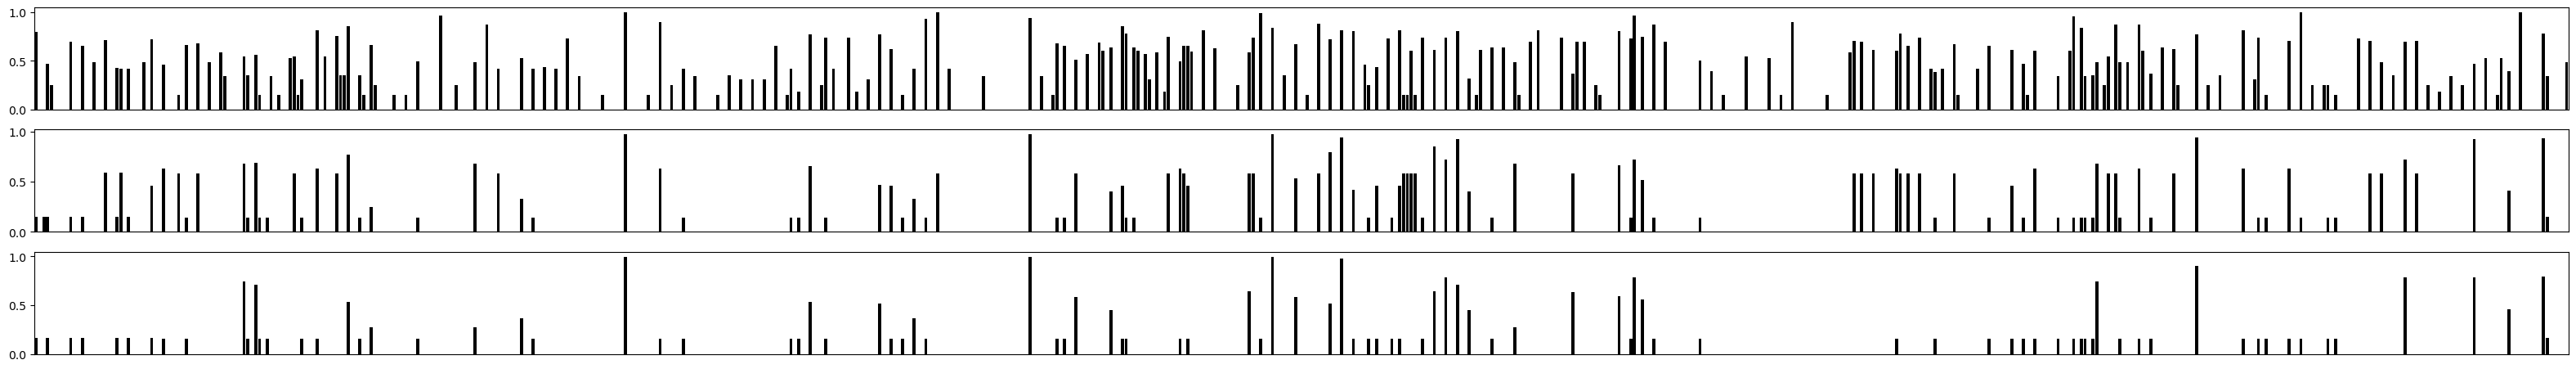

In [6]:
fig, axes = plt.subplots(3, 1, figsize=(40, 5.5))

for idx, data in enumerate([entropy_a, entropy_b, entropy_c]):
    axes[idx] = sns.barplot(data=data, x='positions', y='entropy', color='black', ax=axes[idx])
    axes[idx].set_ylabel(None)
    axes[idx].set_xticks([])
    axes[idx].set_xlabel(None)

In [7]:
fig.figure.savefig("../Figures/Figure5a.pdf", format='pdf', bbox_inches='tight')

# Figure5b

In [8]:
import glob

In [9]:
def load_perturb(file_name):
    delta = []
    with open(file_name, 'r') as f:
        base = f.readline().strip().split('\t')
        base = float(base[-1])
        for line in f:
            items = line.strip().split('\t')
            score = float(items[-1])
            
            delta.append(score - base)
            
    return pd.DataFrame({
        'delta': delta,
        'position': range(len(delta))
    })

In [10]:
tmp = []
tested = glob.glob("*.preds.txt")
for file_name in tested:
    df = load_perturb(file_name)
    df['species'] = file_name.split('.')[0]
    tmp.append(df)
    
df = pd.concat(tmp)
df['species'] = pd.Categorical(df['species'], ordered=True, categories=['A_mitchellae', 'A_nigromaculis', 'A_taeniorhynchus', 'A_sierrensis'])

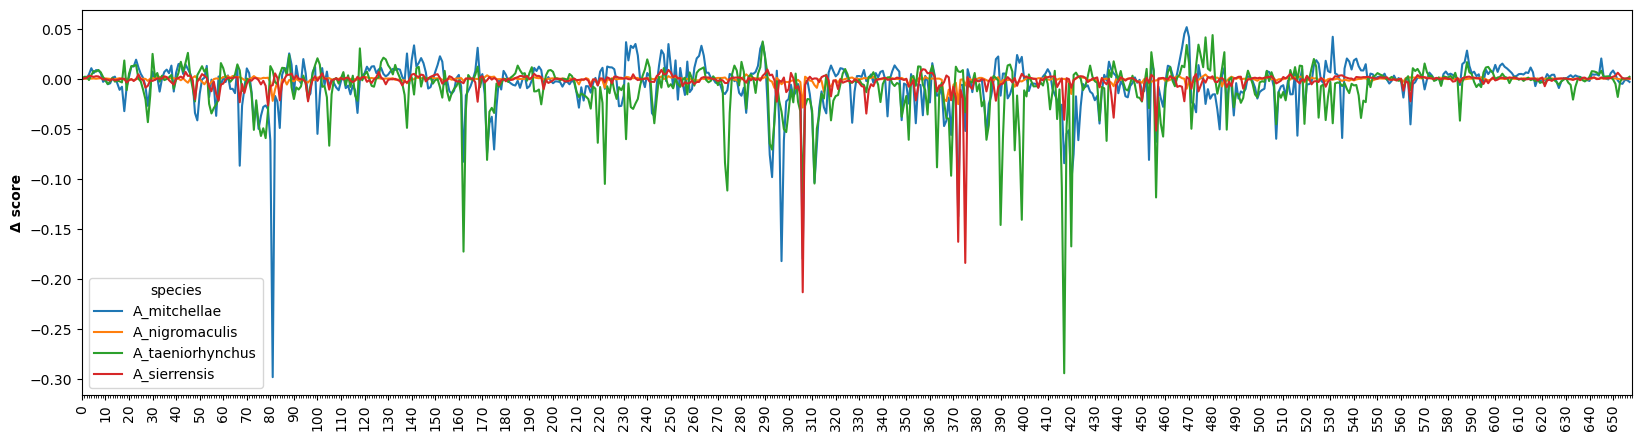

In [11]:
plt.figure(figsize=(20, 5))

ax = sns.lineplot(data=df,
                  x='position', y='delta',
                  hue='species')
ax.set_xlim((0, 658))
ax.set_xlabel(None)
ax.set_ylabel("Δ score", fontweight='bold')

ax.set_xticks(np.arange(0, 658, 10))
ax.xaxis.set_minor_locator(AutoMinorLocator(10))
ax.tick_params(axis='x', rotation=90)

fig.figure.savefig("../Figures/Figure5b.pdf", format='pdf', bbox_inches='tight')

# Statistical analysis

In [12]:
from scipy.stats import fisher_exact

In [13]:
sp1, sp2, sp3, sp4 = ['A_mitchellae', 'A_nigromaculis', 'A_taeniorhynchus', 'A_sierrensis']

In [14]:
df['entropy_3'] = np.array(entropy_c['entropy'] * 4)
df['entropy_4'] = np.array(entropy_b['entropy'] * 4)
df['entropy_all'] = np.array(entropy_a['entropy'] * 4)
df.head()

,delta,position,species,entropy_3,entropy_4,entropy_all
0,-0.0007,0,A_mitchellae,0.162326,0.143726,0.793936
1,0.0009,1,A_mitchellae,0.000000,0.000000,0.000000
2,0.0003,2,A_mitchellae,0.000000,0.143726,0.000000
3,0.0045,3,A_mitchellae,0.162326,0.143726,0.467277
4,0.0106,4,A_mitchellae,0.000000,0.000000,0.249882


In [16]:
delta_cutoff = -0.05
entropy_cutoff = 0.2

tmp = {}
for species in ['A_mitchellae', 'A_nigromaculis', 'A_taeniorhynchus', 'A_sierrensis']:
    subdf = df.query("species == @species")
    tmp[species] = {}
    
    n_low_delta = sum(subdf['delta'] <= delta_cutoff)
    tmp[species]['low delta'] = n_low_delta
    for ent_group in ['entropy_3', 'entropy_4', 'entropy_all']:
        n_high_entropy = sum(subdf[ent_group] >= entropy_cutoff)
        n_overlap = 0
        
        for idx, delta in enumerate(subdf['delta']):
            if delta > delta_cutoff:
                continue
                
            for i in range(max(0, idx-3), min(idx+3, subdf.shape[0])):
                entropy = subdf[ent_group][i]
                if entropy >= entropy_cutoff:
                    n_overlap += 1
                    break
                    
        print(species, ent_group)
        print(n_high_entropy)
        print(n_overlap)
                    
        PP = n_overlap
        PN = n_low_delta - PP
        NP = n_high_entropy - PP
        NN = subdf.shape[0] - PP - PN - NP
        
        table = [[PP, PN], [NP, NN]]
        stats = fisher_exact(table)
        tmp[species][ent_group] = stats.pvalue

A_mitchellae entropy_3
33
11
A_mitchellae entropy_4
79
19
A_mitchellae entropy_all
200
29
A_nigromaculis entropy_3
33
0
A_nigromaculis entropy_4
79
0
A_nigromaculis entropy_all
200
0
A_taeniorhynchus entropy_3
33
12
A_taeniorhynchus entropy_4
79
22
A_taeniorhynchus entropy_all
200
33
A_sierrensis entropy_3
33
2
A_sierrensis entropy_4
79
2
A_sierrensis entropy_all
200
4


In [17]:
pd.DataFrame(tmp)

,A_mitchellae,A_nigromaculis,A_taeniorhynchus,A_sierrensis
low delta,3.000000e+01,0.0,3.300000e+01,4.000000
entropy_3,2.495537e-08,1.0,5.296952e-09,0.013749
entropy_4,7.713644e-12,1.0,2.252691e-14,0.072720
entropy_all,4.911240e-15,1.0,1.182149e-18,0.008358
